In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from a5_utils import *

# Exercise 2

### b

In [2]:
temp = cv2.imread('data/epipolar/house1.jpg') # 0-255
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
temp = temp.astype(np.float64) / 255
temp2 = cv2.imread('data/epipolar/house2.jpg') # 0-255
temp2 = cv2.cvtColor(temp2, cv2.COLOR_BGR2GRAY)
temp2 = temp2.astype(np.float64) / 255
data = np.loadtxt("data/epipolar/house_points.txt")
print(data)
# display_matches(temp, data[:,0:2], temp2, data[:,2:4])

[[192.20093   44.911215 190.1112    46.260498]
 [323.19159   64.051402 296.41291   68.954121]
 [132.38785   68.836449 143.52955   67.162519]
 [313.02336  112.5      285.6633   120.31337 ]
 [103.67757  110.10748  111.87792  104.78616 ]
 [277.13551  170.51869  238.48445  176.45023 ]
 [ 87.528037 153.1729   102.32271  144.7986  ]
 [275.93925  245.88318  239.67885  256.47512 ]
 [321.3972   209.99533  311.34292  225.42068 ]
 [281.32243  192.64953  243.85925  199.74106 ]]


In [109]:
def fundamental_matrix(data):    
    normalized1, T1 = normalize_points(data[:, 0:2])
    normalized2, T2 = normalize_points(data[:, 2:4])
    normalizedData = np.zeros((len(normalized1), 6))
    normalizedData[:, 0:3] = normalized1
    normalizedData[:, 3:6] = normalized2
    A = np.array([])
    for d in normalizedData:
        A = np.append(A, [d[0]*d[3], d[3]*d[1], d[3], d[0]*d[4], d[1]*d[4], d[4], d[0], d[1], 1], 0)
    A = np.reshape(A, (int(len(data)), 9))
    U, D, VT = np.linalg.svd(A)
    F = np.reshape(VT.T[:, 8], (3,3))
    U, D, VT = np.linalg.svd(F)
    D[2] = 0
    F = np.matmul(np.matmul(U, np.diag(D)), VT)
    F = np.matmul(np.matmul(T2.T, F), T1) # transforming F back from normalizedData to original space F = T2.T * F * T1    
    return F

F = fundamental_matrix(data)
print(F)
U, D, VT = np.linalg.svd(F)
e1 = VT.T[:,2]
e2 = U[:, 2]
# print(F.dot(e1)) # should be zero (numerical errors)
# print(F.T.dot(e2)) # should be zero (numerical errors)

[[-8.85211824e-07 -5.61591880e-06  1.94310952e-03]
 [ 9.39281870e-06  6.16883199e-07 -1.20066302e-02]
 [-1.20308414e-03  1.10370070e-02 -8.53173359e-02]]


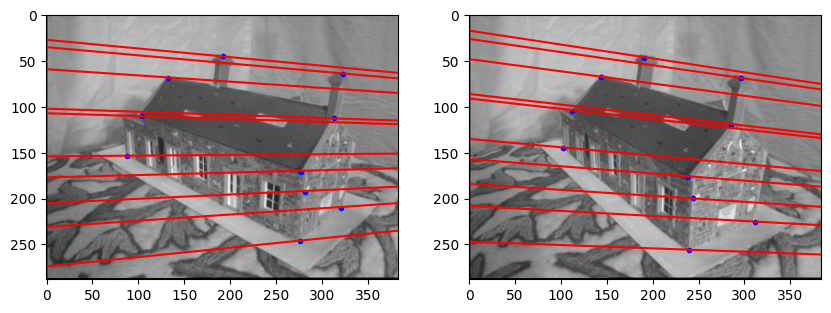

In [146]:
f = plt.figure(figsize=(10, 10))
f.add_subplot(1, 2, 1)
plt.imshow(temp, cmap='gray')

for d in data:
    x1 = d[0]
    y1 = d[1]
    x2 = d[2]
    y2 = d[3]
    plt.plot(x1, y1, 'bo', markersize=3)
    line = F.T.dot(np.array([x2, y2, 1]))
    line = line / line[2]
    draw_epiline(line, temp.shape[0], temp.shape[1])

f.add_subplot(1, 2, 2)
plt.imshow(temp2, cmap="gray")

for d in data:
    x1 = d[2]
    y1 = d[3]
    x2 = d[0]
    y2 = d[1]
    plt.plot(x1, y1, 'bo', markersize=3)
    line = F.dot(np.array([x2, y2, 1]))
    line = line / line[2]
    draw_epiline(line, temp.shape[0], temp.shape[1])

plt.show()

### c

In [153]:
def reprojection_error(F, p1, p2):
    line2 = F.dot(np.array([p1[0], p1[1], 1]))
    line2 = line2 / line2[2]

    distance2 = np.abs(line2[0] * p2[0] + line2[1] * p2[1] + line2[2]) / np.sqrt(line2[0]**2 + line2[1]**2)
    
    line = F.T.dot(np.array([p2[0], p2[1], 1]))
    line = line / line[2]

    distance1 = np.abs(line[0] * p1[0] + line[1] * p1[1] + line[2]) / np.sqrt(line[0]**2 + line[1]**2)

    return (distance1 + distance2) / 2

p1 = np.array([85, 233])
p2 = np.array([67, 219])
print(reprojection_error(F, p1, p2))

sum = 0.0
for d in data:
    sum += reprojection_error(F, d[0:2], d[2:4])
print(sum / len(data))

0.14674365570455666
0.33091336980542574
